In [1]:
import numpy as np
import warnings
warnings.simplefilter("ignore", UserWarning)

import pandas as pd
import pickle
from collections import Counter
from typing import Type, List
import optuna
from datetime import datetime
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import wordpunct_tokenize

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import OneHotEncoder

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

In [2]:
DATA_PATH = "./scrapped_data/scrapped_data_topics.csv"
MEAN_TARGET_ENCODING_PATH = "./mean_target_encoding"
TEST_RATIO = 0.2

In [3]:
data = pd.read_csv(DATA_PATH, index_col=False)
train_data, test_data = train_test_split(data, test_size=TEST_RATIO)
train_data.reset_index(drop=True, inplace=True)
test_data.reset_index(drop=True, inplace=True)

# assert data.isna().sum().sum() == 0
# assert train_data.isna().sum().sum() == 0
print(train_data.shape, test_data.shape)

(7946, 30) (1987, 30)


In [4]:
def estimate_mean_target_regularization(category, global_mean: float, category_means: pd.Series,
                                        category_counts: pd.Series, alpha: float = 10) -> float:
    try:
        return (category_counts[category] * category_means[category] + global_mean * alpha) / (category_counts[category] * alpha)
    except:
        return global_mean

In [5]:
def mean_target_regularization(dataset: pd.DataFrame, column: str, target_name: str,
                               train: bool = True, alpha: float = 10) -> pd.Series:
    encoding_file_path = MEAN_TARGET_ENCODING_PATH + "_" + column + ".pickle"
    if train:
        encoding = {
            "global_mean": dataset[target_name].mean(),
            "counts": dataset.groupby(dataset[column]).count()[target_name],
            "category_means": dataset.groupby(dataset[column]).mean()[target_name]
        }
        with open(encoding_file_path, "wb") as output_file:
            pickle.dump(encoding, output_file)
    else:
        with open(encoding_file_path, "rb") as input_file:
            encoding = pickle.load(input_file)
    
    global_mean = encoding["global_mean"]
    counts = encoding["counts"]
    category_means = encoding["category_means"]
    
    target_mean = dataset[column].apply(
        lambda category: estimate_mean_target_regularization(
            category,
            global_mean=global_mean,
            category_means=category_means,
            category_counts=counts,
            alpha=alpha
        )
    )
    
    return target_mean

In [6]:
train_data.columns

Index(['title', 'publication', 'link', 'author', 'followers', 'reading_time',
       'n_words', 'pure_text', 'date', 'responses', 'n_code_chunks',
       'bold_text_count', 'italic_text_count', 'mean_image_width',
       'mean_image_height', 'n_images', 'n_lists', 'n_vids', 'n_links',
       'claps', 'year', 'month', 'dow', 'language', 'season', 'key_word_1',
       'key_word_2', 'key_word_3', 'topic', 'topic_name'],
      dtype='object')

In [7]:
def preprocess_data(data: pd.DataFrame, train: bool = True):
    MOST_COMMON_COUNT = 50
    result_data = data.copy()
    
    # Mean target encoding with regularization
    result_data["author_mean_target"] = mean_target_regularization(result_data, "author", "claps", train=train)
    result_data["publication_mean_target"] = mean_target_regularization(result_data, "publication", "claps", train=train)
    
    
    # Add title len as a feature
    result_data["title_char_len"] = result_data["title"].apply(len)
    result_data["title_token_len"] = result_data["title"].apply(lambda title: len(wordpunct_tokenize(title)))
    
    # Encode dates
    dates = result_data["date"].apply(lambda date: pd.Timestamp(date))
    result_data["day"] = dates.dt.day
    result_data["month"] = dates.dt.month
    result_data["year"] = dates.dt.year
    result_data["ago"] = abs(result_data["date"].apply(lambda date: pd.Timestamp(date).date()) - datetime.today().date())
    result_data["ago"] = pd.to_numeric(result_data['ago'].dt.days, downcast='integer')
    # Season encoding
    
    result_data['winter'] = [1 if season=='winter' else 0 for season in result_data['season']]
    result_data['summer'] = [1 if season=='summer' else 0 for season in result_data['season']]
    result_data['spring'] = [1 if season=='spring' else 0 for season in result_data['season']]
    result_data['fall'] = [1 if season=='fall' else 0 for season in result_data['season']]
    
    keyword_columns = [f"key_word_{idx}" for idx in range(1, 4)]

    num_cols = ['followers', 'reading_time', 'n_words', 'responses', 'n_code_chunks', 'bold_text_count',
       'italic_text_count', 'mean_image_width', 'mean_image_height',
       'n_images', 'n_lists', 'n_vids', 'n_links']
    for col in num_cols:
        result_data[col] = result_data[col].astype('int64')

    # Filling nans in keyword_1, ..., keyword_10 columns
    for keyword_column in keyword_columns:
        result_data[keyword_column].fillna("<unk>", inplace=True)
        
    # Concat topics in one column
    all_topics = result_data[keyword_columns[0]]
    for keyword_column in keyword_columns[1:]:
        all_topics += " " + result_data[keyword_column]
    
    assert all_topics.isna().sum() == 0
    result_data["all_topics"] = all_topics
    
    # Lemmatize keyword columns
    lemmatizer = WordNetLemmatizer()
    result_data[keyword_columns] = result_data[keyword_columns].applymap(lemmatizer.lemmatize)
    
    if train:
        # Count topics for keyword_columns
        topics = []
        for keyword_column in keyword_columns:
            topics += result_data[keyword_column].tolist()

        topics_counter = Counter(topics)

        most_common_topics = set([topic for topic, _ in topics_counter.most_common()[-MOST_COMMON_COUNT:]])
        
        with open("most_common_topics.pickle", "wb") as output_file:
            pickle.dump(most_common_topics, output_file)
            
        # Use CountVectorizer on topics
        vectorizer = CountVectorizer(vocabulary=most_common_topics)
        vectorizer.fit(result_data["all_topics"])
        with open("topics_vectorizer.pickle", "wb") as output_file:
            pickle.dump(vectorizer, output_file)
            
        # One-hot encode language, analytic, polarity, emotion
        one_hot_encoder = OneHotEncoder(handle_unknown="ignore")
        one_hot_encoder.fit(result_data[["language", "dow"]])
        with open("one_hot_encoder.pickle", "wb") as output_file:
            pickle.dump(one_hot_encoder, output_file)
    else:
        with open("most_common_topics.pickle", "rb") as input_file:
            most_common_topics = pickle.load(input_file)
        with open("topics_vectorizer.pickle", "rb") as input_file:
            vectorizer = pickle.load(input_file)
        with open("one_hot_encoder.pickle", "rb") as input_file:
            one_hot_encoder = pickle.load(input_file)

    topics_vectorized = pd.DataFrame(vectorizer.transform(result_data["all_topics"]).toarray())
    result_data = pd.concat([result_data, topics_vectorized.add_suffix("_vectorizer")], axis=1)
    assert result_data.isna().sum().sum() == 0
    
    categorials_encoded = pd.DataFrame(one_hot_encoder.transform(result_data[["language", "dow"]]).toarray())
    result_data = pd.concat([result_data, categorials_encoded.add_suffix("_one_hot")], axis=1)
    assert result_data.isna().sum().sum() == 0
    
    assert len(most_common_topics) == MOST_COMMON_COUNT
    assert result_data[keyword_columns].isin(most_common_topics).sum().sum() > 0
    assert result_data.isna().sum().sum() == 0
    
    drop_columns = ["date", "author", "link", "topic_name", "publication", "season", "pure_text", "title", "all_topics", "language", "dow"] + keyword_columns
    result_data.drop(drop_columns, inplace=True, axis=1)
    
    return result_data

In [8]:
train_data_preprocessed = preprocess_data(train_data, train=True)
test_data_preprocessed = preprocess_data(test_data, train=False)

C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


In [9]:
class Regressor:
    def train(self, X: np.ndarray, y: np.ndarray) -> None:
        raise NotImplementedError
        
    def predict(self, X: np.ndarray) -> np.ndarray:
        raise NotImplementedError

In [10]:
class MyCB(Regressor):
    def __init__(self):
        self.regressor = CatBoostRegressor(verbose=False, loss_function="MAE")
        
    def train(self, X: np.ndarray, y: np.ndarray) -> None:
        self.regressor.fit(X, y)
        
    def predict(self, X: np.ndarray) -> np.ndarray:
        return self.regressor.predict(X)
    
class MyLGBM(Regressor):
    def __init__(self):
        self.regressor = LGBMRegressor(objective="mae")
        
    def train(self, X: np.ndarray, y: np.ndarray) -> None:
        self.regressor.fit(X, y)
        
    def predict(self, X: np.ndarray) -> np.ndarray:
        return self.regressor.predict(X)
    
class MyXGB(Regressor):
    def __init__(self):
        self.regressor = XGBRegressor()
        
    def train(self, X: np.ndarray, y: np.ndarray) -> None:
        self.regressor.fit(X, y)
        
    def predict(self, X: np.ndarray) -> np.ndarray:
        return self.regressor.predict(X)

In [51]:
from sklearn.metrics import mean_squared_error
def cross_validate(trial, data: pd.DataFrame, RegressorClasses: List[Type[Regressor]]):
    NUM_FOLDS = 5
    kfold = KFold(NUM_FOLDS, shuffle=True)
    
    # Optimize weights for model predictions
    weights = np.zeros(len(RegressorClasses))
    for idx in range(len(RegressorClasses) - 1):
        weights[idx] = trial.suggest_float(f"x_{idx}", 0, 1 - weights.sum())
    weights[-1] = 1 - weights.sum() # num_models x 1
    print("Current weights:", weights)
    
    mae_history = []
    mse_history = []
    for fold_idx, (train_idx, test_idx) in enumerate(kfold.split(data)):
        train_df = data.iloc[train_idx].reset_index(drop=True)
        test_df = data.iloc[test_idx].reset_index(drop=True)
        
        train_df_preprocessed = preprocess_data(train_df, train=True)
        test_df_preprocessed = preprocess_data(test_df, train=False)
        
        X_train = train_df_preprocessed.drop(["claps"], axis=1)
        X_test = test_df_preprocessed.drop(["claps"], axis=1)
        
        y_train = train_df_preprocessed["claps"].to_numpy()
        y_test = test_df_preprocessed["claps"].to_numpy()
        
        regressors = []
        for RegressorClass in RegressorClasses:
            current_regressor = RegressorClass()
            current_regressor.train(X_train, y_train)
            regressors.append(current_regressor)
        
        predictions = []
        for regressor in regressors:
            predictions.append(regressor.predict(X_test))
        predictions = np.vstack(predictions) # num_models x test_size
        
        final_predictions = np.sum(predictions * weights[:, None], axis=0)
        current_loss = mean_absolute_error(y_test, final_predictions)
        mae_history.append(current_loss)
        mse_history.append(mean_squared_error(y_test, final_predictions))
        print(f"Fold number: {fold_idx + 1}, loss: {current_loss}")
        
    return np.mean(mae_history)

In [52]:
X_train = train_data_preprocessed.drop(["claps"], axis=1).to_numpy()
X_test = test_data_preprocessed.drop(["claps"], axis=1).to_numpy()

y_train = train_data_preprocessed["claps"].to_numpy()
y_test = test_data_preprocessed["claps"].to_numpy()

In [54]:
study = optuna.create_study()

objective_wrapper = lambda trial: cross_validate(trial, data, [MyCB, MyLGBM, MyXGB])
study.optimize(objective_wrapper, timeout=60*40)

[I 2022-12-21 00:23:01,946] A new study created in memory with name: no-name-8e07f9ea-baaa-48eb-973b-b011ed2e64c9
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Current weights: [0.94342801 0.00242267 0.05414932]
Fold number: 1, loss: 263.8872524299777


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 2, loss: 357.66844126475104


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 3, loss: 355.69125999485425


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 4, loss: 323.13550827501155


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
[I 2022-12-21 00:23:22,767] Trial 0 finished with value: 340.65523987075824 and parameters: {'x_0': 0.9434280088885648, 'x_1': 0.0024226703821752793}. Best is trial 0 with value: 340.65523987075824.


Fold number: 5, loss: 402.8937373891966
Current weights: [0.85016662 0.07725952 0.07257386]


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 1, loss: 321.62134904023503


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 2, loss: 364.338656802387


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 3, loss: 273.7650993048891


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 4, loss: 337.6116640699383


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
[I 2022-12-21 00:23:49,351] Trial 1 finished with value: 324.43704932087496 and parameters: {'x_0': 0.8501666172224752, 'x_1': 0.07725952013422649}. Best is trial 1 with value: 324.43704932087496.


Fold number: 5, loss: 324.84847738692537
Current weights: [0.56901241 0.31364454 0.11734306]


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 1, loss: 370.92469255314245


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 2, loss: 321.2652439282402


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 3, loss: 335.7813509782818


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 4, loss: 271.398970202701


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
[I 2022-12-21 00:24:10,899] Trial 2 finished with value: 325.3443323711161 and parameters: {'x_0': 0.5690124061569766, 'x_1': 0.31364453737076886}. Best is trial 1 with value: 324.43704932087496.


Fold number: 5, loss: 327.351404193215
Current weights: [0.79100526 0.05914227 0.14985247]


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 1, loss: 337.1187312372435


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 2, loss: 293.4348424750598


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 3, loss: 362.08450837152117


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 4, loss: 316.27476929565984


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
[I 2022-12-21 00:24:32,572] Trial 3 finished with value: 329.5133868143189 and parameters: {'x_0': 0.791005262711468, 'x_1': 0.05914226559313025}. Best is trial 1 with value: 324.43704932087496.


Fold number: 5, loss: 338.65408269211014
Current weights: [0.62099902 0.3466086  0.03239239]


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 1, loss: 402.0270152287838


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 2, loss: 302.5596487735036


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 3, loss: 343.28189661550385


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 4, loss: 296.62069883082876


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
[I 2022-12-21 00:24:53,758] Trial 4 finished with value: 338.6595700088246 and parameters: {'x_0': 0.620999015182478, 'x_1': 0.3466085960196159}. Best is trial 1 with value: 324.43704932087496.


Fold number: 5, loss: 348.80859059550295
Current weights: [0.64770303 0.32640618 0.0258908 ]


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 1, loss: 373.6631781547827


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 2, loss: 312.88168653116526


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 3, loss: 394.47377270912466


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 4, loss: 371.2970298988005


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
[I 2022-12-21 00:25:14,867] Trial 5 finished with value: 351.9070564332785 and parameters: {'x_0': 0.6477030251302532, 'x_1': 0.3264061778488288}. Best is trial 1 with value: 324.43704932087496.


Fold number: 5, loss: 307.21961487251957
Current weights: [0.21766771 0.74995989 0.0323724 ]


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 1, loss: 330.83287249686265


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 2, loss: 369.15232304642547


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 3, loss: 346.26882902872495


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 4, loss: 373.1429274345827


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
[I 2022-12-21 00:25:35,992] Trial 6 finished with value: 363.833494624699 and parameters: {'x_0': 0.21766770713251726, 'x_1': 0.7499598934818068}. Best is trial 1 with value: 324.43704932087496.


Fold number: 5, loss: 399.7705211168992
Current weights: [0.33753395 0.03566663 0.62679943]


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 1, loss: 332.19835878794936


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 2, loss: 290.1583253545636


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 3, loss: 250.0012140807078


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 4, loss: 309.9633448872724


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
[I 2022-12-21 00:25:55,628] Trial 7 finished with value: 293.3019640295066 and parameters: {'x_0': 0.3375339462726895, 'x_1': 0.03566662648845866}. Best is trial 7 with value: 293.3019640295066.


Fold number: 5, loss: 284.18857703704003
Current weights: [0.71172272 0.11656102 0.17171627]


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 1, loss: 359.99165797719536


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 2, loss: 327.61018425841417


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 3, loss: 324.22415931143627


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 4, loss: 284.06901521042465


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
[I 2022-12-21 00:26:16,485] Trial 8 finished with value: 318.51064770923074 and parameters: {'x_0': 0.7117227159795927, 'x_1': 0.11656101773783485}. Best is trial 7 with value: 293.3019640295066.


Fold number: 5, loss: 296.6582217886832
Current weights: [0.07200062 0.46286216 0.46513722]


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 1, loss: 335.4934959615447


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 2, loss: 322.09348745788867


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 3, loss: 275.5322353336897


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 4, loss: 393.1665501925399


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
[I 2022-12-21 00:26:37,381] Trial 9 finished with value: 322.51364787930635 and parameters: {'x_0': 0.07200062288636011, 'x_1': 0.462862158179608}. Best is trial 7 with value: 293.3019640295066.


Fold number: 5, loss: 286.2824704508687
Current weights: [0.34287504 0.21519214 0.44193281]


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 1, loss: 336.78637151625924


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 2, loss: 355.82622588610394


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 3, loss: 308.87292372775386


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 4, loss: 250.82826938683644


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
[I 2022-12-21 00:26:59,722] Trial 10 finished with value: 315.61887268533025 and parameters: {'x_0': 0.3428750446355664, 'x_1': 0.21519214207365772}. Best is trial 7 with value: 293.3019640295066.


Fold number: 5, loss: 325.7805729096976
Current weights: [0.3553189  0.20220201 0.44247909]


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 1, loss: 325.2655871276291


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 2, loss: 283.4555087631644


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 3, loss: 295.36490224399773


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 4, loss: 322.9656910660142


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
[I 2022-12-21 00:27:23,483] Trial 11 finished with value: 306.874642877692 and parameters: {'x_0': 0.35531890364555485, 'x_1': 0.2022020051450163}. Best is trial 7 with value: 293.3019640295066.


Fold number: 5, loss: 307.3215251876546
Current weights: [0.41970205 0.17563455 0.4046634 ]


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 1, loss: 327.6570526932832


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 2, loss: 315.7154881938893


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 3, loss: 324.01140948391145


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 4, loss: 318.18876883165007


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
[I 2022-12-21 00:27:44,916] Trial 12 finished with value: 310.2351164062731 and parameters: {'x_0': 0.41970204680973444, 'x_1': 0.17563455214610987}. Best is trial 7 with value: 293.3019640295066.


Fold number: 5, loss: 265.6028628286315
Current weights: [0.27191395 0.4973059  0.23078015]


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 1, loss: 332.607295676868


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 2, loss: 364.60184373972504


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 3, loss: 332.40491679950094


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 4, loss: 410.76982380334545


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
[I 2022-12-21 00:28:06,687] Trial 13 finished with value: 349.59351153783336 and parameters: {'x_0': 0.2719139472875649, 'x_1': 0.49730590323599816}. Best is trial 7 with value: 293.3019640295066.


Fold number: 5, loss: 307.5836776697274
Current weights: [0.1236237  0.59195451 0.28442179]


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 1, loss: 347.23694620283766


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 2, loss: 289.2570269165562


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 3, loss: 337.82805284336706


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 4, loss: 361.07263626721596


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
[I 2022-12-21 00:28:30,679] Trial 14 finished with value: 333.1727853494451 and parameters: {'x_0': 0.12362370364258926, 'x_1': 0.5919545050474078}. Best is trial 7 with value: 293.3019640295066.


Fold number: 5, loss: 330.4692645172488
Current weights: [0.45712939 0.18966749 0.35320313]


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 1, loss: 295.655460775117


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 2, loss: 307.59225994042623


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 3, loss: 355.9108089010123


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 4, loss: 341.8855319530693


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
[I 2022-12-21 00:28:52,119] Trial 15 finished with value: 316.2818670916053 and parameters: {'x_0': 0.4571293851809577, 'x_1': 0.18966748830043118}. Best is trial 7 with value: 293.3019640295066.


Fold number: 5, loss: 280.36527388840176
Current weights: [0.00141704 0.92062126 0.0779617 ]


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 1, loss: 321.6043344119862


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 2, loss: 446.46143446428414


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 3, loss: 318.56104222346676


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 4, loss: 401.99904957418045


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
[I 2022-12-21 00:29:13,963] Trial 16 finished with value: 384.13047994601436 and parameters: {'x_0': 0.0014170392754302985, 'x_1': 0.9206212641285797}. Best is trial 7 with value: 293.3019640295066.


Fold number: 5, loss: 432.02653905615426
Current weights: [0.36537764 0.23926824 0.39535411]


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 1, loss: 298.64016594022587


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 2, loss: 271.2125841628894


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 3, loss: 307.47589708817185


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 4, loss: 289.4115774169859


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
[I 2022-12-21 00:29:35,092] Trial 17 finished with value: 318.7650649788391 and parameters: {'x_0': 0.3653776406672924, 'x_1': 0.2392682449374434}. Best is trial 7 with value: 293.3019640295066.


Fold number: 5, loss: 427.0851002859225
Current weights: [0.2115355  0.11461104 0.67385345]


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 1, loss: 288.59818555359965


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 2, loss: 296.3752802881197


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 3, loss: 299.51167505999905


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 4, loss: 314.41049851757305


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
[I 2022-12-21 00:29:57,400] Trial 18 finished with value: 306.08783444654114 and parameters: {'x_0': 0.21153550243296582, 'x_1': 0.11461104301022035}. Best is trial 7 with value: 293.3019640295066.


Fold number: 5, loss: 331.54353281341423
Current weights: [0.19557192 0.00101622 0.80341187]


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 1, loss: 275.92898845270753


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 2, loss: 277.09581366033507


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 3, loss: 303.6457950034919


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 4, loss: 293.69948596645617


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
[I 2022-12-21 00:30:19,793] Trial 19 finished with value: 282.2052161524865 and parameters: {'x_0': 0.19557191847517255, 'x_1': 0.0010162161928214813}. Best is trial 19 with value: 282.2052161524865.


Fold number: 5, loss: 260.65599767944207
Current weights: [0.52293207 0.01620845 0.46085948]


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 1, loss: 264.519200163179


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 2, loss: 285.97121563848816


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 3, loss: 356.78185322385355


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 4, loss: 303.57886270978264


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
[I 2022-12-21 00:30:41,661] Trial 20 finished with value: 307.9602320500443 and parameters: {'x_0': 0.5229320677614251, 'x_1': 0.016208449430127003}. Best is trial 19 with value: 282.2052161524865.


Fold number: 5, loss: 328.95002851491796
Current weights: [0.19055357 0.11506293 0.6943835 ]


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 1, loss: 264.41643459818414


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 2, loss: 309.7100077391945


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 3, loss: 365.0946248219684


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 4, loss: 268.0532750476473


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
[I 2022-12-21 00:31:02,592] Trial 21 finished with value: 304.34827007394495 and parameters: {'x_0': 0.190553568444561, 'x_1': 0.11506293376312846}. Best is trial 19 with value: 282.2052161524865.


Fold number: 5, loss: 314.4670081627304
Current weights: [0.14421612 0.00432737 0.8514565 ]


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 1, loss: 281.72133460394355


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 2, loss: 254.870815814503


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 3, loss: 326.2008266489797


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 4, loss: 249.80151438869382


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
[I 2022-12-21 00:31:24,164] Trial 22 finished with value: 290.8126528614231 and parameters: {'x_0': 0.14421612288066973, 'x_1': 0.004327374357227895}. Best is trial 19 with value: 282.2052161524865.


Fold number: 5, loss: 341.4687728509954
Current weights: [0.10719391 0.00183615 0.89096994]


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 1, loss: 354.1374993542918


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 2, loss: 355.700581176094


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 3, loss: 265.93611771268166


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 4, loss: 259.5388576011606


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
[I 2022-12-21 00:31:45,138] Trial 23 finished with value: 299.7098757654996 and parameters: {'x_0': 0.107193911398774, 'x_1': 0.0018361526214160182}. Best is trial 19 with value: 282.2052161524865.


Fold number: 5, loss: 263.2363229832702
Current weights: [0.2811863  0.06252361 0.65629009]


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 1, loss: 253.91993478718183


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 2, loss: 339.038217374289


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 3, loss: 289.25803250061495


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 4, loss: 317.59389220927955


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
[I 2022-12-21 00:32:07,972] Trial 24 finished with value: 301.6099688241005 and parameters: {'x_0': 0.28118630218603624, 'x_1': 0.06252361083103275}. Best is trial 19 with value: 282.2052161524865.


Fold number: 5, loss: 308.2397672491373
Current weights: [0.03816414 0.41625702 0.54557884]


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 1, loss: 299.9318620996119


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 2, loss: 396.12453720544954


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 3, loss: 324.5200366540447


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 4, loss: 289.18647782166994


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
[I 2022-12-21 00:32:27,897] Trial 25 finished with value: 320.7993522712049 and parameters: {'x_0': 0.03816413858606395, 'x_1': 0.41625702309500995}. Best is trial 19 with value: 282.2052161524865.


Fold number: 5, loss: 294.2338475752486
Current weights: [0.15421155 0.14774652 0.69804194]


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 1, loss: 256.6270031348231


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 2, loss: 302.42556615549324


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 3, loss: 305.5534994045865


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 4, loss: 350.40015146561853


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
[I 2022-12-21 00:32:48,792] Trial 26 finished with value: 306.72064184099065 and parameters: {'x_0': 0.1542115459134844, 'x_1': 0.14774651510403594}. Best is trial 19 with value: 282.2052161524865.


Fold number: 5, loss: 318.5969890444319
Current weights: [0.27891262 0.27045764 0.45062974]


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 1, loss: 304.24493385271165


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 2, loss: 324.75914606723546


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 3, loss: 251.0546519367152


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 4, loss: 379.42806118476574


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
[I 2022-12-21 00:33:10,186] Trial 27 finished with value: 313.48377626506243 and parameters: {'x_0': 0.27891262401297073, 'x_1': 0.27045764052184107}. Best is trial 19 with value: 282.2052161524865.


Fold number: 5, loss: 307.9320882838842
Current weights: [0.39371394 0.03949413 0.56679193]


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 1, loss: 290.8711010964604


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 2, loss: 284.20454761599086


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 3, loss: 267.51241797139


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 4, loss: 266.5089939009184


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
[I 2022-12-21 00:33:31,383] Trial 28 finished with value: 292.0439133945855 and parameters: {'x_0': 0.3937139449099176, 'x_1': 0.039494127044062924}. Best is trial 19 with value: 282.2052161524865.


Fold number: 5, loss: 351.122506388168
Current weights: [0.42570777 0.08959306 0.48469918]


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 1, loss: 287.5984344411612


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 2, loss: 317.43649858860294


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 3, loss: 248.1631635427039


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 4, loss: 297.0029543593704


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
[I 2022-12-21 00:33:52,067] Trial 29 finished with value: 303.6379972518183 and parameters: {'x_0': 0.42570776840570446, 'x_1': 0.08959305559364641}. Best is trial 19 with value: 282.2052161524865.


Fold number: 5, loss: 367.98893532725333
Current weights: [0.48505868 0.04302782 0.4719135 ]


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 1, loss: 273.8669836205616


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 2, loss: 345.1256939723183


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 3, loss: 283.32155226571894


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 4, loss: 289.6968296010367


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
[I 2022-12-21 00:34:11,613] Trial 30 finished with value: 303.1590400194735 and parameters: {'x_0': 0.4850586803310488, 'x_1': 0.04302782365804764}. Best is trial 19 with value: 282.2052161524865.


Fold number: 5, loss: 323.78414063773204
Current weights: [0.28821525 0.0021388  0.70964595]


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 1, loss: 268.54703754066395


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 2, loss: 310.9444807460381


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 3, loss: 298.9819810504056


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 4, loss: 279.35366191356434


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
[I 2022-12-21 00:34:32,816] Trial 31 finished with value: 284.2364280946466 and parameters: {'x_0': 0.2882152532240142, 'x_1': 0.002138795422840449}. Best is trial 19 with value: 282.2052161524865.


Fold number: 5, loss: 263.35497922256127
Current weights: [0.2251873 0.0131719 0.7616408]


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 1, loss: 291.48358885543996


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 2, loss: 322.70837603007715


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 3, loss: 271.16550589138427


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 4, loss: 337.5575944243588


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
[I 2022-12-21 00:34:53,617] Trial 32 finished with value: 292.30982503670873 and parameters: {'x_0': 0.22518730456706076, 'x_1': 0.013171898430519531}. Best is trial 19 with value: 282.2052161524865.


Fold number: 5, loss: 238.63405998228367
Current weights: [0.976272   0.00455499 0.01917301]


c:\Users\Aleksey Ryabykin\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\samplers\_tpe\parzen_estimator.py:193: RuntimeWarning: divide by zero encountered in divide
  coefficient = 1 / z / p_accept
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 1, loss: 354.3361288870197


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 2, loss: 359.94083492557115


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 3, loss: 288.84110979542635


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 4, loss: 320.7591364892712


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
[I 2022-12-21 00:35:14,018] Trial 33 finished with value: 340.3430992258365 and parameters: {'x_0': 0.9762719981754091, 'x_1': 0.004554987363410822}. Best is trial 19 with value: 282.2052161524865.


Fold number: 5, loss: 377.8382860318943
Current weights: [0.15891541 0.14567436 0.69541023]


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 1, loss: 283.4603065814348


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 2, loss: 317.0512446650617


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 3, loss: 319.4367747688006


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 4, loss: 307.28572173810164


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
[I 2022-12-21 00:35:36,474] Trial 34 finished with value: 310.109541827179 and parameters: {'x_0': 0.15891541050429597, 'x_1': 0.14567435996493755}. Best is trial 19 with value: 282.2052161524865.


Fold number: 5, loss: 323.3136613824961
Current weights: [0.28776239 0.07845207 0.63378554]


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 1, loss: 263.7565823633529


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 2, loss: 265.1341566667016


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 3, loss: 307.4492711344071


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 4, loss: 304.30512889216453


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
[I 2022-12-21 00:35:57,452] Trial 35 finished with value: 295.0431847770576 and parameters: {'x_0': 0.28776238710679125, 'x_1': 0.07845207358066403}. Best is trial 19 with value: 282.2052161524865.


Fold number: 5, loss: 334.57078482866206
Current weights: [0.54389137 0.04190695 0.41420168]


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 1, loss: 325.5519111463901


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 2, loss: 311.9711792825802


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 3, loss: 291.70802067909455


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 4, loss: 285.82652078666126


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
[I 2022-12-21 00:36:18,864] Trial 36 finished with value: 301.42436430452875 and parameters: {'x_0': 0.5438913700288486, 'x_1': 0.041906947886861876}. Best is trial 19 with value: 282.2052161524865.


Fold number: 5, loss: 292.06418962791787
Current weights: [0.40178204 0.08254438 0.51567358]


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 1, loss: 266.36117868263125


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 2, loss: 295.1698075662399


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 3, loss: 296.37125610649775


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 4, loss: 280.64565609208574


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
[I 2022-12-21 00:36:40,097] Trial 37 finished with value: 298.4934235141075 and parameters: {'x_0': 0.4017820390870902, 'x_1': 0.0825443806452442}. Best is trial 19 with value: 282.2052161524865.


Fold number: 5, loss: 353.919219123083
Current weights: [0.6003445  0.03043253 0.36922297]


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 1, loss: 311.9074722844317


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 2, loss: 274.9869782893206


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 3, loss: 272.9393877611094


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 4, loss: 360.4514089807574


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
[I 2022-12-21 00:36:59,954] Trial 38 finished with value: 303.1364174404438 and parameters: {'x_0': 0.6003445010284697, 'x_1': 0.030432526012148117}. Best is trial 19 with value: 282.2052161524865.


Fold number: 5, loss: 295.39683988659976
Current weights: [0.08129729 0.27873704 0.63996567]


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 1, loss: 308.75508078078155


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 2, loss: 283.40383509197926


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 3, loss: 304.7357174610022


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 4, loss: 312.05942640023045


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
[I 2022-12-21 00:37:19,850] Trial 39 finished with value: 310.534982713884 and parameters: {'x_0': 0.08129728897631894, 'x_1': 0.2787370447243068}. Best is trial 19 with value: 282.2052161524865.


Fold number: 5, loss: 343.7208538354265
Current weights: [0.86344075 0.04805847 0.08850078]


c:\Users\Aleksey Ryabykin\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\samplers\_tpe\parzen_estimator.py:193: RuntimeWarning: divide by zero encountered in divide
  coefficient = 1 / z / p_accept
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 1, loss: 329.6713722739302


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 2, loss: 331.3417601216246


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 3, loss: 392.5157874435389


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 4, loss: 321.46791570449824


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
[I 2022-12-21 00:37:41,892] Trial 40 finished with value: 337.23107023791823 and parameters: {'x_0': 0.863440751378915, 'x_1': 0.04805846618934828}. Best is trial 19 with value: 282.2052161524865.


Fold number: 5, loss: 311.1585156459991
Current weights: [2.16896960e-01 1.45875492e-04 7.82957165e-01]


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 1, loss: 287.70114426859004


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 2, loss: 292.7114494296981


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 3, loss: 271.1790247941797


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 4, loss: 327.26014197000154


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
[I 2022-12-21 00:38:03,113] Trial 41 finished with value: 292.86333160737547 and parameters: {'x_0': 0.21689695953933733, 'x_1': 0.00014587549233199284}. Best is trial 19 with value: 282.2052161524865.


Fold number: 5, loss: 285.46489757440804
Current weights: [0.23937751 0.14419088 0.61643161]


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 1, loss: 256.7971963590698


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 2, loss: 347.7409325337804


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 3, loss: 255.9367141929093


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 4, loss: 318.64807183742636


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
[I 2022-12-21 00:38:23,884] Trial 42 finished with value: 295.3604473521718 and parameters: {'x_0': 0.23937751062306278, 'x_1': 0.14419087916244336}. Best is trial 19 with value: 282.2052161524865.


Fold number: 5, loss: 297.67932183767306
Current weights: [0.1635318  0.09203738 0.74443082]


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 1, loss: 303.0201523824304


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 2, loss: 303.80137852573205


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 3, loss: 269.0076905326529


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 4, loss: 327.73156270360533


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
[I 2022-12-21 00:38:45,070] Trial 43 finished with value: 292.74421706257874 and parameters: {'x_0': 0.16353180071524945, 'x_1': 0.09203737863014266}. Best is trial 19 with value: 282.2052161524865.


Fold number: 5, loss: 260.16030116847276
Current weights: [0.25548748 0.05456931 0.68994321]


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 1, loss: 282.8147744932508


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 2, loss: 326.92863192337063


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 3, loss: 308.6946782855994


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 4, loss: 271.27357034854987


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
[I 2022-12-21 00:39:06,212] Trial 44 finished with value: 292.5516075003198 and parameters: {'x_0': 0.2554874830822642, 'x_1': 0.05456930683160713}. Best is trial 19 with value: 282.2052161524865.


Fold number: 5, loss: 273.0463824508284
Current weights: [0.31702156 0.03055293 0.65242551]


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 1, loss: 287.9263066305922


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 2, loss: 310.2993248236015


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 3, loss: 279.38147756536637


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 4, loss: 320.3014594611318


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
[I 2022-12-21 00:39:25,671] Trial 45 finished with value: 292.7803617871464 and parameters: {'x_0': 0.317021562435366, 'x_1': 0.030552930862301264}. Best is trial 19 with value: 282.2052161524865.


Fold number: 5, loss: 265.99324045503994
Current weights: [0.38145914 0.06840421 0.55013665]


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 1, loss: 253.14599134046418


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 2, loss: 282.7292526199401


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 3, loss: 311.15955363246195


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 4, loss: 300.3192783650665


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
[I 2022-12-21 00:39:46,751] Trial 46 finished with value: 300.80350961799513 and parameters: {'x_0': 0.38145913584208235, 'x_1': 0.06840421056666805}. Best is trial 19 with value: 282.2052161524865.


Fold number: 5, loss: 356.6634721320429
Current weights: [0.32338517 0.09846599 0.57814884]


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 1, loss: 291.91671257037575


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 2, loss: 284.91434785273185


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 3, loss: 272.2302417948094


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 4, loss: 319.3810675887769


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
[I 2022-12-21 00:40:08,415] Trial 47 finished with value: 299.51965313738634 and parameters: {'x_0': 0.3233851690462236, 'x_1': 0.09846599043954658}. Best is trial 19 with value: 282.2052161524865.


Fold number: 5, loss: 329.1558958802377
Current weights: [0.13288471 0.3532999  0.51381539]


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 1, loss: 278.50415367216567


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 2, loss: 359.0390739710981


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 3, loss: 304.40481877740905


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 4, loss: 359.88880251071913


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
[I 2022-12-21 00:40:30,404] Trial 48 finished with value: 322.154665248081 and parameters: {'x_0': 0.13288470668231675, 'x_1': 0.35329990047144694}. Best is trial 19 with value: 282.2052161524865.


Fold number: 5, loss: 308.936477309013
Current weights: [0.18974238 0.60636557 0.20389206]


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 1, loss: 342.355219056969


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 2, loss: 377.5364162567718


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 3, loss: 282.0475214512951


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 4, loss: 364.0690040320447


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
[I 2022-12-21 00:40:51,698] Trial 49 finished with value: 344.9301704632867 and parameters: {'x_0': 0.1897423788069904, 'x_1': 0.6063655651350975}. Best is trial 19 with value: 282.2052161524865.


Fold number: 5, loss: 358.6426915193529
Current weights: [0.06365461 0.15976716 0.77657823]


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 1, loss: 291.9853285703447


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 2, loss: 307.30644675831036


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 3, loss: 329.2828579365301


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 4, loss: 255.93196883266572


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
[I 2022-12-21 00:41:14,321] Trial 50 finished with value: 311.6595703712668 and parameters: {'x_0': 0.0636546123742214, 'x_1': 0.15976715921979268}. Best is trial 19 with value: 282.2052161524865.


Fold number: 5, loss: 373.791249758483
Current weights: [0.24893904 0.05263373 0.69842723]


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 1, loss: 286.05281514084385


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 2, loss: 262.3352043458422


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 3, loss: 361.51718603210173


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 4, loss: 282.72284573586205


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
[I 2022-12-21 00:41:36,773] Trial 51 finished with value: 297.14815884526195 and parameters: {'x_0': 0.2489390372202469, 'x_1': 0.052633732486620274}. Best is trial 19 with value: 282.2052161524865.


Fold number: 5, loss: 293.1127429716597
Current weights: [0.31851554 0.02801678 0.65346768]


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 1, loss: 275.0711421290039


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 2, loss: 343.576330210276


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 3, loss: 363.979044373253


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 4, loss: 294.6529468832497


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
[I 2022-12-21 00:41:58,589] Trial 52 finished with value: 316.4616003860629 and parameters: {'x_0': 0.31851554161766027, 'x_1': 0.028016777150799976}. Best is trial 19 with value: 282.2052161524865.


Fold number: 5, loss: 305.02853833453196
Current weights: [0.24626082 0.11223355 0.64150562]


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 1, loss: 281.5152755818756


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 2, loss: 318.8691054269706


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 3, loss: 273.5758477116427


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 4, loss: 282.48930552580833


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
[I 2022-12-21 00:42:19,013] Trial 53 finished with value: 301.5192080128936 and parameters: {'x_0': 0.24626082406756392, 'x_1': 0.11223355462552623}. Best is trial 19 with value: 282.2052161524865.


Fold number: 5, loss: 351.146505818171
Current weights: [0.4541159  0.01544163 0.53044246]


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 1, loss: 238.398309257679


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 2, loss: 271.7150542130929


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 3, loss: 387.72798754677024


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 4, loss: 324.84800562232004


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
[I 2022-12-21 00:42:39,470] Trial 54 finished with value: 304.9694698001657 and parameters: {'x_0': 0.4541159047696452, 'x_1': 0.015441632855981392}. Best is trial 19 with value: 282.2052161524865.


Fold number: 5, loss: 302.15799236096666
Current weights: [0.20026934 0.13187448 0.66785618]


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 1, loss: 316.13350023070103


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 2, loss: 264.58526218381263


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 3, loss: 267.9366792289078


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 4, loss: 325.6720770102173


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
[I 2022-12-21 00:43:00,715] Trial 55 finished with value: 301.7188372723184 and parameters: {'x_0': 0.20026933661325214, 'x_1': 0.13187447973069616}. Best is trial 19 with value: 282.2052161524865.


Fold number: 5, loss: 334.2666677079533
Current weights: [0.36727506 0.06214095 0.570584  ]


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 1, loss: 300.90042880756715


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 2, loss: 292.8145916776805


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 3, loss: 328.11530802210973


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 4, loss: 302.83812950583064


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
[I 2022-12-21 00:43:21,148] Trial 56 finished with value: 304.4605517863941 and parameters: {'x_0': 0.36727505728556226, 'x_1': 0.062140946933655516}. Best is trial 19 with value: 282.2052161524865.


Fold number: 5, loss: 297.63430091878246
Current weights: [0.0923619  0.22011727 0.68752082]


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 1, loss: 275.8764666044168


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 2, loss: 291.2296904782262


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 3, loss: 311.65734237868105


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 4, loss: 275.0867296627384


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
[I 2022-12-21 00:43:41,374] Trial 57 finished with value: 305.6771950358291 and parameters: {'x_0': 0.09236190471655853, 'x_1': 0.2201172719856782}. Best is trial 19 with value: 282.2052161524865.


Fold number: 5, loss: 374.5357460550829
Current weights: [0.02237464 0.85821536 0.11941   ]


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 1, loss: 416.11315588698517


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 2, loss: 363.286642723253


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 3, loss: 296.7749518357384


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 4, loss: 361.87991044782854


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
[I 2022-12-21 00:44:02,673] Trial 58 finished with value: 365.08474227055683 and parameters: {'x_0': 0.022374638543947306, 'x_1': 0.8582153564610646}. Best is trial 19 with value: 282.2052161524865.


Fold number: 5, loss: 387.3690504589792
Current weights: [0.1337827  0.56286873 0.30334857]


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 1, loss: 336.0014016161704


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 2, loss: 332.5342260183417


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 3, loss: 331.8994548936578


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 4, loss: 311.4270718824854


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
[I 2022-12-21 00:44:24,320] Trial 59 finished with value: 327.86158095524263 and parameters: {'x_0': 0.1337827002112232, 'x_1': 0.5628687277313205}. Best is trial 19 with value: 282.2052161524865.


Fold number: 5, loss: 327.4457503655577
Current weights: [0.29625111 0.17790689 0.525842  ]


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 1, loss: 331.32038501685014


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 2, loss: 286.24464176009957


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 3, loss: 288.3340189869994


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 4, loss: 335.78858310234324


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
[I 2022-12-21 00:44:46,397] Trial 60 finished with value: 306.30107152574647 and parameters: {'x_0': 0.2962511097535504, 'x_1': 0.17790689147970323}. Best is trial 19 with value: 282.2052161524865.


Fold number: 5, loss: 289.8177287624402
Current weights: [0.15487871 0.08804963 0.75707166]


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 1, loss: 275.1831309052038


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 2, loss: 294.8942717999965


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 3, loss: 267.59914210838315


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 4, loss: 315.17504197627557


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
[I 2022-12-21 00:45:07,212] Trial 61 finished with value: 291.5864360156095 and parameters: {'x_0': 0.15487871439516185, 'x_1': 0.0880496251045243}. Best is trial 19 with value: 282.2052161524865.


Fold number: 5, loss: 305.0805932881883
Current weights: [0.17616208 0.00252303 0.8213149 ]


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 1, loss: 266.2383284431895


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 2, loss: 309.3480347531378


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 3, loss: 232.09209129176895


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 4, loss: 322.04432177257314


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
[I 2022-12-21 00:45:29,031] Trial 62 finished with value: 291.081363061887 and parameters: {'x_0': 0.17616207732064337, 'x_1': 0.0025230263704741776}. Best is trial 19 with value: 282.2052161524865.


Fold number: 5, loss: 325.6840390487656
Current weights: [0.18078671 0.00302712 0.81618617]


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 1, loss: 256.3034241971267


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 2, loss: 239.78093309813875


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 3, loss: 317.9702359272342


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 4, loss: 260.2264452862439


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
[I 2022-12-21 00:45:50,690] Trial 63 finished with value: 284.2028221798995 and parameters: {'x_0': 0.18078670853723053, 'x_1': 0.0030271186630183335}. Best is trial 19 with value: 282.2052161524865.


Fold number: 5, loss: 346.7330723907538
Current weights: [0.17552155 0.00413047 0.82034798]


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 1, loss: 296.2337148705058


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 2, loss: 271.0059178672205


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 3, loss: 314.70928147503525


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 4, loss: 305.74984736761763


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
[I 2022-12-21 00:46:12,391] Trial 64 finished with value: 295.48777392435994 and parameters: {'x_0': 0.17552154623972208, 'x_1': 0.004130469445214174}. Best is trial 19 with value: 282.2052161524865.


Fold number: 5, loss: 289.7401080414207
Current weights: [0.10782381 0.11131614 0.78086005]


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 1, loss: 281.9337366415578


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 2, loss: 293.14458888706434


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 3, loss: 260.84942852825833


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 4, loss: 315.79078135982417


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
[I 2022-12-21 00:46:34,093] Trial 65 finished with value: 292.1755390811409 and parameters: {'x_0': 0.10782380865942509, 'x_1': 0.11131614399232459}. Best is trial 19 with value: 282.2052161524865.


Fold number: 5, loss: 309.1591599889998
Current weights: [0.05141871 0.08206826 0.86651303]


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 1, loss: 256.3355014922002


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 2, loss: 276.1357129124318


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 3, loss: 343.34562145486143


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 4, loss: 289.62109436171914


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
[I 2022-12-21 00:46:55,798] Trial 66 finished with value: 292.70342270064486 and parameters: {'x_0': 0.051418708213173736, 'x_1': 0.0820682575620745}. Best is trial 19 with value: 282.2052161524865.


Fold number: 5, loss: 298.0791832820116
Current weights: [0.71107998 0.07404724 0.21487278]


c:\Users\Aleksey Ryabykin\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\samplers\_tpe\parzen_estimator.py:193: RuntimeWarning: divide by zero encountered in divide
  coefficient = 1 / z / p_accept
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 1, loss: 285.3415817990329


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 2, loss: 265.0269186262317


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 3, loss: 368.5924426045896


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 4, loss: 311.9194606724186


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
[I 2022-12-21 00:47:17,589] Trial 67 finished with value: 311.0640302139491 and parameters: {'x_0': 0.7110799811172686, 'x_1': 0.07404723690897096}. Best is trial 19 with value: 282.2052161524865.


Fold number: 5, loss: 324.4397473674727
Current weights: [1.35468672e-01 3.33327318e-04 8.64198000e-01]


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 1, loss: 328.82767848218236


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 2, loss: 293.5938034134541


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 3, loss: 281.6646465419668


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 4, loss: 313.2463310016734


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
[I 2022-12-21 00:47:39,365] Trial 68 finished with value: 303.37682807072105 and parameters: {'x_0': 0.13546867230817217, 'x_1': 0.0003333273184197346}. Best is trial 19 with value: 282.2052161524865.


Fold number: 5, loss: 299.5516809143286
Current weights: [0.1906429  0.03785481 0.77150229]


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 1, loss: 259.7376829728557


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 2, loss: 325.77830585043245


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 3, loss: 331.23603879490383


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 4, loss: 263.08874949902093


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
[I 2022-12-21 00:48:00,932] Trial 69 finished with value: 293.7274603666662 and parameters: {'x_0': 0.19064290156655445, 'x_1': 0.03785481009666744}. Best is trial 19 with value: 282.2052161524865.


Fold number: 5, loss: 288.7965247161182
Current weights: [0.22032982 0.02955906 0.75011111]


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 1, loss: 262.5254967485854


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 2, loss: 259.37284484110387


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 3, loss: 325.4670369029555


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 4, loss: 396.0207991988961


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
[I 2022-12-21 00:48:22,460] Trial 70 finished with value: 298.96077692445886 and parameters: {'x_0': 0.2203298214678826, 'x_1': 0.029559063902062574}. Best is trial 19 with value: 282.2052161524865.


Fold number: 5, loss: 251.41770693075324
Current weights: [0.09942908 0.11198584 0.78858508]


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 1, loss: 256.6004982897912


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 2, loss: 308.38192462816863


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 3, loss: 286.8163373644355


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 4, loss: 370.6272255795837


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
[I 2022-12-21 00:48:43,350] Trial 71 finished with value: 299.05730491607875 and parameters: {'x_0': 0.0994290759447659, 'x_1': 0.11198584370022546}. Best is trial 19 with value: 282.2052161524865.


Fold number: 5, loss: 272.86053871841443
Current weights: [0.00121342 0.66641858 0.332368  ]


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 1, loss: 393.8240912799446


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 2, loss: 370.5912200608043


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 3, loss: 365.65999479867156


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 4, loss: 323.0800504918198


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
[I 2022-12-21 00:49:04,298] Trial 72 finished with value: 355.8897798573612 and parameters: {'x_0': 0.0012134187008070452, 'x_1': 0.6664185815179526}. Best is trial 19 with value: 282.2052161524865.


Fold number: 5, loss: 326.2935426555657
Current weights: [0.12124088 0.12748197 0.75127715]


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 1, loss: 286.2242749812238


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 2, loss: 253.50990462688412


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 3, loss: 301.4413908441513


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 4, loss: 250.7886735658402


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
[I 2022-12-21 00:49:25,246] Trial 73 finished with value: 293.88732971402254 and parameters: {'x_0': 0.12124088259006637, 'x_1': 0.12748196825648175}. Best is trial 19 with value: 282.2052161524865.


Fold number: 5, loss: 377.47240455201313
Current weights: [0.15993523 0.05613703 0.78392774]


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 1, loss: 270.6435872114499


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 2, loss: 268.8905725984408


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 3, loss: 346.01819432263136


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 4, loss: 309.06883950376306


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
[I 2022-12-21 00:49:47,336] Trial 74 finished with value: 292.0934084771292 and parameters: {'x_0': 0.15993522549020942, 'x_1': 0.05613703175766506}. Best is trial 19 with value: 282.2052161524865.


Fold number: 5, loss: 265.84584874936064
Current weights: [0.16241997 0.04656357 0.79101645]


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 1, loss: 288.670490270625


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 2, loss: 260.50287624058325


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 3, loss: 305.08033746199305


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 4, loss: 336.25810068937625


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
[I 2022-12-21 00:50:09,876] Trial 75 finished with value: 307.8318502697463 and parameters: {'x_0': 0.16241997342261066, 'x_1': 0.046563571904147796}. Best is trial 19 with value: 282.2052161524865.


Fold number: 5, loss: 348.64744668615424
Current weights: [0.26505909 0.02200143 0.71293948]


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 1, loss: 301.68906674921493


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 2, loss: 282.49488029098103


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 3, loss: 275.42569936063506


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 4, loss: 306.0688905808206


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
[I 2022-12-21 00:50:30,530] Trial 76 finished with value: 293.5040020789005 and parameters: {'x_0': 0.2650590878459516, 'x_1': 0.022001432463269913}. Best is trial 19 with value: 282.2052161524865.


Fold number: 5, loss: 301.8414734128509
Current weights: [0.34196574 0.02202191 0.63601236]


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 1, loss: 274.0461327865517


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 2, loss: 349.28567251940814


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 3, loss: 318.0143665499639


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 4, loss: 246.82269630199914


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
[I 2022-12-21 00:50:52,208] Trial 77 finished with value: 294.6837193065148 and parameters: {'x_0': 0.34196573620274406, 'x_1': 0.02202190551298956}. Best is trial 19 with value: 282.2052161524865.


Fold number: 5, loss: 285.24972837465094
Current weights: [0.29712852 0.06336557 0.63950592]


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 1, loss: 244.73962487914122


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 2, loss: 345.26054041612554


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 3, loss: 316.8043316287201


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 4, loss: 315.78697870888504


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
[I 2022-12-21 00:51:14,347] Trial 78 finished with value: 307.3274778519566 and parameters: {'x_0': 0.29712851609318364, 'x_1': 0.06336556883880101}. Best is trial 19 with value: 282.2052161524865.


Fold number: 5, loss: 314.0459136269111
Current weights: [0.14498538 0.09161691 0.76339771]


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 1, loss: 299.37908853317975


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 2, loss: 302.32253368189646


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 3, loss: 331.9908974004343


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 4, loss: 259.561843482352


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
[I 2022-12-21 00:51:35,116] Trial 79 finished with value: 295.96785199060776 and parameters: {'x_0': 0.1449853816810054, 'x_1': 0.09161690820184719}. Best is trial 19 with value: 282.2052161524865.


Fold number: 5, loss: 286.58489685517645
Current weights: [0.21552616 0.04792039 0.73655344]


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 1, loss: 272.86000535844533


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 2, loss: 290.58681275351034


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 3, loss: 295.71820435795814


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 4, loss: 341.74552173588336


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
[I 2022-12-21 00:51:55,323] Trial 80 finished with value: 305.85751475169957 and parameters: {'x_0': 0.2155261648426485, 'x_1': 0.04792039097109622}. Best is trial 19 with value: 282.2052161524865.


Fold number: 5, loss: 328.3770295527008
Current weights: [0.07980911 0.16000785 0.76018304]


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 1, loss: 306.5034450313863


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 2, loss: 336.4055016769324


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 3, loss: 305.14062691264564


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 4, loss: 293.51596322492867


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
[I 2022-12-21 00:52:15,395] Trial 81 finished with value: 308.2513916318977 and parameters: {'x_0': 0.07980910531640317, 'x_1': 0.16000785476447058}. Best is trial 19 with value: 282.2052161524865.


Fold number: 5, loss: 299.69142131359564
Current weights: [0.16481398 0.10594022 0.7292458 ]


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 1, loss: 267.76112430518


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 2, loss: 260.61811710337844


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 3, loss: 353.9959661011959


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 4, loss: 308.5071315160557


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
[I 2022-12-21 00:52:35,619] Trial 82 finished with value: 299.3610457841651 and parameters: {'x_0': 0.1648139809111058, 'x_1': 0.10594021893185934}. Best is trial 19 with value: 282.2052161524865.


Fold number: 5, loss: 305.92288989501543
Current weights: [0.10227854 0.39891544 0.49880602]


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 1, loss: 357.6859124935774


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 2, loss: 298.21715203337925


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 3, loss: 317.63992803082675


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 4, loss: 401.5838502932266


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
[I 2022-12-21 00:52:56,197] Trial 83 finished with value: 332.37806689372275 and parameters: {'x_0': 0.10227854210598897, 'x_1': 0.3989154427583272}. Best is trial 19 with value: 282.2052161524865.


Fold number: 5, loss: 286.7634916176038
Current weights: [0.18684356 0.05891512 0.75424132]


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 1, loss: 275.0467118268383


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 2, loss: 276.6504444526029


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 3, loss: 380.91658028898513


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 4, loss: 305.95547927504924


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
[I 2022-12-21 00:53:20,069] Trial 84 finished with value: 299.3130587252511 and parameters: {'x_0': 0.18684355698261731, 'x_1': 0.05891512121037896}. Best is trial 19 with value: 282.2052161524865.


Fold number: 5, loss: 257.9960777827796
Current weights: [0.23494891 0.45136029 0.3136908 ]


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 1, loss: 352.2932744545402


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 2, loss: 312.0248788526638


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 3, loss: 287.62192367165306


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 4, loss: 406.9232389205067


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
[I 2022-12-21 00:53:40,887] Trial 85 finished with value: 344.38056489403783 and parameters: {'x_0': 0.23494891023385212, 'x_1': 0.4513602928962941}. Best is trial 19 with value: 282.2052161524865.


Fold number: 5, loss: 363.03950857082526
Current weights: [0.04322442 0.08821412 0.86856146]


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 1, loss: 319.6341111060797


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 2, loss: 288.54980143697543


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 3, loss: 308.7012493617044


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 4, loss: 265.1150154433543


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
[I 2022-12-21 00:54:00,869] Trial 86 finished with value: 290.5215902539873 and parameters: {'x_0': 0.04322442481879235, 'x_1': 0.08821411626693897}. Best is trial 19 with value: 282.2052161524865.


Fold number: 5, loss: 270.60777392182274
Current weights: [0.0340072  0.18717294 0.77881986]


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 1, loss: 273.1362822250255


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 2, loss: 361.6164196479945


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 3, loss: 260.1173981578601


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 4, loss: 316.4600983511995


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
[I 2022-12-21 00:54:21,438] Trial 87 finished with value: 295.3535605299899 and parameters: {'x_0': 0.034007203094677425, 'x_1': 0.187172940046152}. Best is trial 19 with value: 282.2052161524865.


Fold number: 5, loss: 265.43760426786986
Current weights: [0.40435191 0.01521561 0.58043248]


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 1, loss: 297.07177528141256


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 2, loss: 322.5442644039339


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 3, loss: 275.5047158402866


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 4, loss: 283.92758169543004


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
[I 2022-12-21 00:54:40,646] Trial 88 finished with value: 303.8131189984337 and parameters: {'x_0': 0.40435190753805694, 'x_1': 0.015215608253798103}. Best is trial 19 with value: 282.2052161524865.


Fold number: 5, loss: 340.01725777110556
Current weights: [0.26776705 0.30496939 0.42726356]


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 1, loss: 290.81445011041313


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 2, loss: 315.6797538120918


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 3, loss: 279.840600173808


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 4, loss: 360.93294382820267


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
[I 2022-12-21 00:55:00,125] Trial 89 finished with value: 317.79566860339844 and parameters: {'x_0': 0.2677670485919095, 'x_1': 0.30496938668569}. Best is trial 19 with value: 282.2052161524865.


Fold number: 5, loss: 341.71059509247635
Current weights: [0.05937435 0.08005701 0.86056864]


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 1, loss: 289.74507434944206


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 2, loss: 294.62261349793766


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 3, loss: 261.9280722472643


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 4, loss: 294.22544220745215


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
[I 2022-12-21 00:55:20,172] Trial 90 finished with value: 295.13483707176886 and parameters: {'x_0': 0.05937434904786207, 'x_1': 0.08005700640447053}. Best is trial 19 with value: 282.2052161524865.


Fold number: 5, loss: 335.1529830567479
Current weights: [0.11337331 0.12229967 0.76432702]


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 1, loss: 275.65582650053545


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 2, loss: 296.19680938427524


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 3, loss: 264.5521289365265


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 4, loss: 285.33355533040265


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
[I 2022-12-21 00:55:39,245] Trial 91 finished with value: 299.4392201668433 and parameters: {'x_0': 0.11337330827532602, 'x_1': 0.12229966815651885}. Best is trial 19 with value: 282.2052161524865.


Fold number: 5, loss: 375.45778068247654
Current weights: [0.14769793 0.038986   0.81331607]


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 1, loss: 264.12243820305156


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 2, loss: 284.59655874400613


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 3, loss: 344.7813410695723


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 4, loss: 267.52733225496223


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
[I 2022-12-21 00:55:59,031] Trial 92 finished with value: 289.3867403838393 and parameters: {'x_0': 0.14769792796122513, 'x_1': 0.03898599893108991}. Best is trial 19 with value: 282.2052161524865.


Fold number: 5, loss: 285.9060316476046
Current weights: [0.1534084  0.0420208  0.80457081]


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 1, loss: 269.27377358716467


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 2, loss: 317.5468864892222


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 3, loss: 254.18433155734493


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 4, loss: 310.2572083077707


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
[I 2022-12-21 00:56:18,602] Trial 93 finished with value: 298.39060537693456 and parameters: {'x_0': 0.15340839504807724, 'x_1': 0.042020795904501765}. Best is trial 19 with value: 282.2052161524865.


Fold number: 5, loss: 340.69082694317035
Current weights: [0.20399455 0.00140967 0.79459578]


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 1, loss: 283.00867880078147


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 2, loss: 297.5502496352934


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 3, loss: 247.94682531315974


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 4, loss: 324.88177567340273


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
[I 2022-12-21 00:56:38,290] Trial 94 finished with value: 282.58698607137416 and parameters: {'x_0': 0.20399454908888925, 'x_1': 0.0014096684681422606}. Best is trial 19 with value: 282.2052161524865.


Fold number: 5, loss: 259.54740093423356
Current weights: [0.19919545 0.01893008 0.78187447]


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 1, loss: 286.5391544531565


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 2, loss: 271.36647121298347


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 3, loss: 294.1060300028418


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 4, loss: 297.630401993099


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
[I 2022-12-21 00:56:59,703] Trial 95 finished with value: 287.06537559337323 and parameters: {'x_0': 0.19919544613373713, 'x_1': 0.018930082978152844}. Best is trial 19 with value: 282.2052161524865.


Fold number: 5, loss: 285.68482030478515
Current weights: [2.09970230e-01 5.38253902e-04 7.89491516e-01]


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 1, loss: 341.4037836351482


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 2, loss: 326.90588999491314


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 3, loss: 273.533299641875


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 4, loss: 258.18777997938287


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
[I 2022-12-21 00:57:21,456] Trial 96 finished with value: 293.7670155783636 and parameters: {'x_0': 0.20997022979337254, 'x_1': 0.000538253901683221}. Best is trial 19 with value: 282.2052161524865.


Fold number: 5, loss: 268.80432464049875
Current weights: [0.19966147 0.0247132  0.77562533]


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 1, loss: 225.53880724660425


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 2, loss: 287.2816350329951


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 3, loss: 310.8343900066701


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 4, loss: 291.57801998598717


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
[I 2022-12-21 00:57:41,108] Trial 97 finished with value: 287.3592294256051 and parameters: {'x_0': 0.199661473552243, 'x_1': 0.02471319894526322}. Best is trial 19 with value: 282.2052161524865.


Fold number: 5, loss: 321.56329485576885
Current weights: [0.18230637 0.0210808  0.79661283]


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 1, loss: 324.3445439621329


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 2, loss: 315.39781847185


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 3, loss: 275.1132847174292


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 4, loss: 262.8518674331705


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
[I 2022-12-21 00:58:02,127] Trial 98 finished with value: 287.84239835140727 and parameters: {'x_0': 0.18230636585258425, 'x_1': 0.021080801091963287}. Best is trial 19 with value: 282.2052161524865.


Fold number: 5, loss: 261.5044771724537
Current weights: [0.23730001 0.0193537  0.74334629]


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 1, loss: 329.066994199831


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 2, loss: 275.0136400809527


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 3, loss: 255.39161748355147


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 4, loss: 252.06672303598788


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
[I 2022-12-21 00:58:23,322] Trial 99 finished with value: 284.7238018482701 and parameters: {'x_0': 0.23730001355307692, 'x_1': 0.019353701159908743}. Best is trial 19 with value: 282.2052161524865.


Fold number: 5, loss: 312.0800344410275
Current weights: [0.25598701 0.02263884 0.72137415]


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 1, loss: 291.78694655278593


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 2, loss: 301.9661743780836


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 3, loss: 295.49262712313714


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 4, loss: 280.6151464776241


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
[I 2022-12-21 00:58:44,865] Trial 100 finished with value: 286.1011745111641 and parameters: {'x_0': 0.2559870086354561, 'x_1': 0.02263883676172833}. Best is trial 19 with value: 282.2052161524865.


Fold number: 5, loss: 260.64497802419
Current weights: [0.23167491 0.02443946 0.74388563]


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 1, loss: 256.6933302853536


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 2, loss: 268.4561856711785


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 3, loss: 372.2851152309444


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 4, loss: 247.32040930519582


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
[I 2022-12-21 00:59:04,884] Trial 101 finished with value: 289.12874381812134 and parameters: {'x_0': 0.23167491236554894, 'x_1': 0.024439461467933632}. Best is trial 19 with value: 282.2052161524865.


Fold number: 5, loss: 300.8886785979343
Current weights: [0.23152384 0.02292381 0.74555235]


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 1, loss: 284.3164667055126


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 2, loss: 289.5189370958561


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 3, loss: 254.67691728462458


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 4, loss: 341.2311889040861


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
[I 2022-12-21 00:59:24,666] Trial 102 finished with value: 301.0118682063369 and parameters: {'x_0': 0.23152383882364047, 'x_1': 0.022923813346426347}. Best is trial 19 with value: 282.2052161524865.


Fold number: 5, loss: 335.31583104160524
Current weights: [0.20175255 0.02865388 0.76959357]


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 1, loss: 282.1466817009255


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 2, loss: 261.89963593301326


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 3, loss: 313.9749756772555


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 4, loss: 316.9214425017598


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
[I 2022-12-21 00:59:44,549] Trial 103 finished with value: 286.0231012614532 and parameters: {'x_0': 0.2017525473174348, 'x_1': 0.02865388442327293}. Best is trial 19 with value: 282.2052161524865.


Fold number: 5, loss: 255.17277049431172
Current weights: [0.25201638 0.01786827 0.73011535]


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 1, loss: 309.29250736395517


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 2, loss: 261.84853076523194


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 3, loss: 299.0671323534588


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 4, loss: 297.25121872004894


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
[I 2022-12-21 01:00:03,909] Trial 104 finished with value: 303.332079269571 and parameters: {'x_0': 0.25201637703249635, 'x_1': 0.01786826956674508}. Best is trial 19 with value: 282.2052161524865.


Fold number: 5, loss: 349.20100714516013
Current weights: [0.27966825 0.03196904 0.6883627 ]


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 1, loss: 251.2092104071681


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 2, loss: 273.03937290770983


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 3, loss: 291.7635821312721


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 4, loss: 334.56292581034864


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
[I 2022-12-21 01:00:23,182] Trial 105 finished with value: 290.5035683841197 and parameters: {'x_0': 0.2796682541499647, 'x_1': 0.03196904469947712}. Best is trial 19 with value: 282.2052161524865.


Fold number: 5, loss: 301.9427506640999
Current weights: [0.30875429 0.01691723 0.67432848]


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 1, loss: 235.1155457476825


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 2, loss: 380.8470603007965


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 3, loss: 302.0953611777294


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 4, loss: 303.15036602607853


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
[I 2022-12-21 01:00:43,430] Trial 106 finished with value: 301.3198634438748 and parameters: {'x_0': 0.30875429087919287, 'x_1': 0.016917227129030016}. Best is trial 19 with value: 282.2052161524865.


Fold number: 5, loss: 285.3909839670871
Current weights: [0.20668595 0.07019315 0.7231209 ]


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 1, loss: 276.21638876020535


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 2, loss: 306.50194314661894


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 3, loss: 373.35921809975764


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 4, loss: 269.1241738051605


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
[I 2022-12-21 01:01:03,659] Trial 107 finished with value: 313.8847427129773 and parameters: {'x_0': 0.20668595190058517, 'x_1': 0.07019314799294987}. Best is trial 19 with value: 282.2052161524865.


Fold number: 5, loss: 344.221989753144
Current weights: [0.18215662 0.06597187 0.75187151]


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 1, loss: 313.3078032861418


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 2, loss: 300.13556172227027


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 3, loss: 324.65093178239067


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 4, loss: 280.6295515654562


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
[I 2022-12-21 01:01:24,125] Trial 108 finished with value: 301.93906808708647 and parameters: {'x_0': 0.18215662380435932, 'x_1': 0.06597186764299233}. Best is trial 19 with value: 282.2052161524865.


Fold number: 5, loss: 290.97149207917346
Current weights: [0.24163568 0.02881223 0.72955209]


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 1, loss: 275.632153490274


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 2, loss: 301.182155777101


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 3, loss: 305.937523416694


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 4, loss: 306.1084011196568


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
[I 2022-12-21 01:01:44,575] Trial 109 finished with value: 295.52907527116906 and parameters: {'x_0': 0.24163567938011932, 'x_1': 0.028812225811953657}. Best is trial 19 with value: 282.2052161524865.


Fold number: 5, loss: 288.78514255211957
Current weights: [0.19814896 0.04330561 0.75854543]


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 1, loss: 335.31175696537855


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 2, loss: 231.7445464409927


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 3, loss: 287.09785669342466


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 4, loss: 340.6031107917425


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
[I 2022-12-21 01:02:06,331] Trial 110 finished with value: 295.2748383324465 and parameters: {'x_0': 0.19814895941224545, 'x_1': 0.04330561294534458}. Best is trial 19 with value: 282.2052161524865.


Fold number: 5, loss: 281.61692077069426
Current weights: [0.22394587 0.01418197 0.76187216]


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 1, loss: 279.05874116404266


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 2, loss: 267.0922182797818


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 3, loss: 255.594973933894


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 4, loss: 270.5188504881375


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
[I 2022-12-21 01:02:27,334] Trial 111 finished with value: 286.86267739409783 and parameters: {'x_0': 0.22394587114752498, 'x_1': 0.01418196861958149}. Best is trial 19 with value: 282.2052161524865.


Fold number: 5, loss: 362.04860310463323
Current weights: [0.25832169 0.01093137 0.73074695]


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 1, loss: 324.04850049027397


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 2, loss: 298.3988787390007


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 3, loss: 272.81187468075245


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 4, loss: 261.7172224616602


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
[I 2022-12-21 01:02:46,205] Trial 112 finished with value: 296.68863330105813 and parameters: {'x_0': 0.2583216853612213, 'x_1': 0.010931367921615727}. Best is trial 19 with value: 282.2052161524865.


Fold number: 5, loss: 326.4666901336035
Current weights: [0.22815792 0.05380691 0.71803517]


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 1, loss: 253.42848806723177


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 2, loss: 260.8297118439616


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 3, loss: 362.01090444370453


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


Fold number: 4, loss: 286.7508295639078


C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
[I 2022-12-21 01:03:04,911] Trial 113 finished with value: 284.65711894857725 and parameters: {'x_0': 0.22815792221949385, 'x_1': 0.053806911332324354}. Best is trial 19 with value: 282.2052161524865.


Fold number: 5, loss: 260.2656608240804


In [53]:
data_preprocessed = preprocess_data(data, train=True)

C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]
C:\Users\Aleksey Ryabykin\AppData\Local\Temp\ipykernel_284956\2963386934.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "category_means": dataset.groupby(dataset[column]).mean()[target_name]


In [16]:
data_preprocessed.isna().sum().sum()

0

In [55]:
study.best_params

{'x_0': 0.19557191847517255, 'x_1': 0.0010162161928214813}

In [18]:
X = data_preprocessed.drop(["claps"], axis=1).to_numpy()
y = data_preprocessed["claps"].to_numpy()

In [56]:
cb = CatBoostRegressor(loss_function="MAE")
cb.fit(X_train, y_train)
# lgb = LGBMRegressor(objective="mae")
lgb = LGBMRegressor(objective="mae")
lgb.fit(X_train, y_train)
xgb = XGBRegressor()
xgb.fit(X_train, y_train)

0:	learn: 697.8784625	total: 3.65ms	remaining: 3.65s
1:	learn: 691.8184588	total: 6.48ms	remaining: 3.23s
2:	learn: 685.4622473	total: 9.4ms	remaining: 3.12s
3:	learn: 677.7599204	total: 13ms	remaining: 3.25s
4:	learn: 672.9033614	total: 15.5ms	remaining: 3.09s
5:	learn: 668.0803357	total: 18.2ms	remaining: 3.01s
6:	learn: 663.6462464	total: 20.7ms	remaining: 2.94s
7:	learn: 657.2346928	total: 23.3ms	remaining: 2.89s
8:	learn: 648.7581427	total: 26ms	remaining: 2.86s
9:	learn: 643.8288154	total: 28.8ms	remaining: 2.85s
10:	learn: 640.6028100	total: 31.3ms	remaining: 2.82s
11:	learn: 636.1142488	total: 33.9ms	remaining: 2.79s
12:	learn: 631.1422179	total: 36.7ms	remaining: 2.79s
13:	learn: 625.7774837	total: 39.6ms	remaining: 2.79s
14:	learn: 618.8401496	total: 42.3ms	remaining: 2.77s
15:	learn: 612.7948210	total: 44.6ms	remaining: 2.75s
16:	learn: 606.8967498	total: 47.3ms	remaining: 2.74s
17:	learn: 602.7748718	total: 49.9ms	remaining: 2.72s
18:	learn: 594.2324907	total: 52.2ms	remain

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [72]:
best_params = study.best_params

In [73]:
cb_weight = best_params["x_0"]#study.best_params["x_0"]
lgb_weight = best_params["x_1"]#study.best_params["x_1"]
xgb_weight = 1 - cb_weight - lgb_weight

In [21]:
cb_pred = cb.predict(X_test)
lgb_pred = lgb.predict(X_test)
xgb_pred = xgb.predict(X_test)

final_pred = cb_weight * cb_pred + lgb_weight * lgb_pred + xgb_weight * xgb_pred
final_pred[final_pred < 0] = 0
final_pred = np.round(final_pred)

In [22]:
cb_pred[cb_pred < 0] = 0
cb_pred = np.round(cb_pred)
lgb_pred[lgb_pred < 0] = 0
lgb_pred = np.round(lgb_pred)
xgb_pred[xgb_pred < 0] = 0
xgb_pred = np.round(xgb_pred)

In [24]:
mean_absolute_error(cb_pred, y_test), mean_absolute_error(lgb_pred, y_test), mean_absolute_error(xgb_pred, y_test)

(370.6794162053347, 408.60442878711626, 307.70005032712635)

In [26]:
from sklearn.model_selection import  GridSearchCV, cross_validate
import time
def results_cv(clf, X_dummy, y):
    grid = GridSearchCV(clf(), 
            {'max_depth': range(3,20)}, cv=5)
            
    grid.fit(X_dummy, y)
    start_time = time.time()
    res_dt = cross_validate(clf(max_depth=grid.best_params_['max_depth']), 
        X_dummy, y, cv=5, scoring=["max_error", "neg_mean_squared_error", "r2"], return_estimator=True)

    print("Wall time: ", time.time() - start_time)

    # print("Average mae through cross-validation: %.3f"%res_dt['max_error'].mean())
    
    # print("Average mse through cross-validation: %.3f"%res_dt['neg_mean_squared_error'].mean())

    # print("Average r2 through cross-validation: %.3f"%res_dt['r2'].mean())


    return res_dt

In [28]:
ress

{'fit_time': array([0.26669669, 0.25669456, 0.29590297, 0.27719355, 0.25125384]),
 'score_time': array([0.00501585, 0.00300956, 0.00350785, 0.0040009 , 0.00301862]),
 'estimator': [XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
               colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
               early_stopping_rounds=None, enable_categorical=False,
               eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
               grow_policy='depthwise', importance_type=None,
               interaction_constraints='', learning_rate=0.300000012, max_bin=256,
               max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
               max_depth=4, max_leaves=0, min_child_weight=1, missing=nan,
               monotone_constraints='()', n_estimators=100, n_jobs=0,
               num_parallel_tree=1, predictor='auto', random_state=0, ...),
  XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
               colsample_byleve

In [30]:
pred_loop = []
for estimator in ress["estimator"]:
    xgb_pred = estimator.predict(X)
    xgb_pred[xgb_pred < 0] = 0
    xgb_pred = np.round(xgb_pred)
    pred_loop.append(xgb_pred)
pred_loop = np.array(pred_loop)

In [45]:
lost_loop = []
for loop in pred_loop:
    lost_loop.append(abs(loop - y))

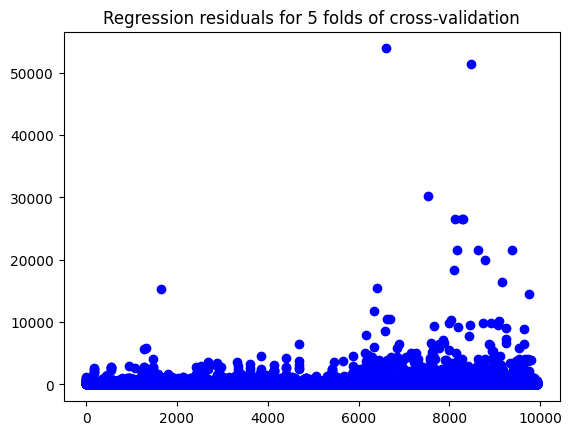

In [46]:
import matplotlib.pyplot as plt
plt.title("Regression residuals for 5 folds of cross-validation")
for loop in lost_loop:
    plt.scatter(range(len(loop)), loop, color="b")

In [47]:
dsa = pd.DataFrame(np.array(lost_loop).T)


In [48]:
import pingouin as pg

In [49]:
pg.homoscedasticity(np.log(dsa+1))

,W,pval,equal_var
levene,30.54541,1.964067e-25,False
